In [10]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
# 定义数据集参数
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
# n_train: 训练样本数量 (20个样本)
# n_test: 测试样本数量 (100个样本)  
# num_inputs: 输入特征维度 (200维)
# batch_size: 批量大小 (每批5个样本)

# 定义真实的模型参数
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
# true_w: 真实权重向量，形状为(200, 1)，所有元素值为0.01
# true_b: 真实偏置项，标量值为0.05

# 生成训练数据
train_data = d2l.synthetic_data(true_w, true_b, n_train)
# train_data: 根据真实参数生成的训练数据集，包含20个样本

# 创建训练数据迭代器
train_iter = d2l.load_array(train_data, batch_size)
# train_iter: 训练数据的批量迭代器，每次返回5个样本

# 生成测试数据
test_data = d2l.synthetic_data(true_w, true_b, n_test)
# test_data: 根据真实参数生成的测试数据集，包含100个样本

# 创建测试数据迭代器
test_iter = d2l.load_array(test_data, batch_size, is_train=False)
# test_iter: 测试数据的批量迭代器，is_train=False表示不打乱数据顺序

In [12]:
def init_params():
    w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]

In [13]:
def l2_penalty(w):
    return torch.sum(w**2)/2

In [16]:
def train(lambd):
    # lambd: 权重衰减的正则化参数，控制L2惩罚项的强度
    
    # 初始化模型参数
    w, b = init_params()
    # w: 权重参数，形状为(num_inputs, 1)，随机初始化
    # b: 偏置参数，标量，初始化为0
    
    # 定义网络和损失函数
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # net: 线性回归网络函数，输入X返回预测值
    # loss: 平方损失函数，用于计算预测值与真实值之间的误差
    
    # 设置训练超参数
    num_epochs, lr = 100, 0.003
    # num_epochs: 训练轮数，总共训练100个epoch
    # lr: 学习率，控制参数更新的步长
    
    # 创建动画器用于可视化训练过程
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
                           xlim=[5, num_epochs], legend=['train', 'test'])
    # animator: 用于实时绘制训练和测试损失曲线的可视化工具
    
    # 开始训练循环
    for epoch in range(num_epochs):
        # epoch: 当前训练轮数
        
        # 遍历训练数据的每个批次
        for X, y in train_iter:
            # X: 输入特征，形状为(batch_size, num_inputs)
            # y: 真实标签，形状为(batch_size, 1)
            
            # 计算总损失：预测损失 + L2正则化惩罚项
            l = loss(net(X), y) + lambd * l2_penalty(w)
            # l: 总损失，包含预测误差和权重衰减惩罚项
            
            # 反向传播计算梯度
            l.sum().backward()
            
            # 使用随机梯度下降更新参数
            d2l.sgd([w, b], lr, batch_size)
        
        # 每5个epoch记录一次训练和测试损失
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, 
                        (d2l.evaluate_loss(net, train_iter, loss),
                         d2l.evaluate_loss(net, test_iter, loss)))
    
    # 输出最终权重的L2范数
    print('w的L2范数是：', torch.norm(w).item())
    # torch.norm(w).item(): 计算权重向量w的L2范数（欧几里得范数）

w的L2范数是： 13.416975021362305


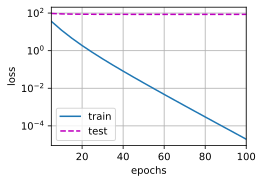

In [17]:
train(lambd=0)

w的L2范数是： 0.36235639452934265


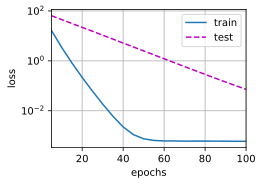

In [18]:
train(lambd=3)

In [19]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias,'bias_decay': 0}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 0.00837522279471159


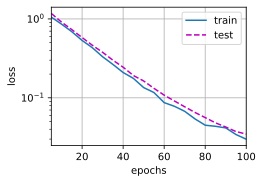

In [29]:
train_concise(500)

In [31]:
# 定义预测函数
def predict_with_model(model, X):
    """使用训练好的模型进行预测"""
    model.eval()  # 设置为评估模式
    with torch.no_grad():
        predictions = model(X)
    return predictions

# 创建一些测试数据
test_X = torch.normal(0.0, 1, (5, num_inputs))
print("测试输入:")
print(test_X)

# 重新训练一个模型用于预测
net = nn.Sequential(nn.Linear(num_inputs, 1))
for param in net.parameters():
    param.data.normal_()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD([
    {"params":net[0].weight,'weight_decay': 3},
    {"params":net[0].bias,'weight_decay': 0}], lr=0.003)

# 简单训练几个epoch
for epoch in range(50):
    for X, y in train_iter:
        trainer.zero_grad()
        l = loss(net(X), y)
        l.mean().backward()
        trainer.step()

# 使用训练好的模型进行预测
predictions = predict_with_model(net, test_X)
print("\n预测结果:")
print(predictions.flatten())


测试输入:
tensor([[-9.9010e-01, -1.3745e+00, -1.0613e+00,  3.7666e-01,  1.4876e-01,
          1.3996e+00,  1.9971e+00, -3.0750e-01,  3.3228e-01,  2.3242e+00,
         -1.0940e+00,  1.5398e+00,  8.1833e-02, -1.6671e+00, -4.7367e-01,
          1.5715e+00,  7.6122e-01, -2.1617e+00, -8.1953e-01,  9.3624e-01,
         -1.8248e+00,  1.3792e+00, -2.9352e-01,  9.0005e-01,  1.3169e+00,
          1.1147e+00,  2.9609e+00, -4.6727e-01,  9.3008e-01,  9.6976e-01,
          5.9364e-01, -3.9820e-01,  5.1435e-02,  1.2684e+00, -7.1493e-01,
         -4.4340e-01, -6.5548e-01, -1.8974e+00, -6.2348e-01,  2.3093e-01,
         -5.6849e-01,  1.5581e+00, -3.6691e-01, -1.0017e+00, -2.7980e-01,
          5.6879e-01, -3.3574e-01, -2.5911e-01, -4.3361e-01,  2.5293e+00,
         -8.1038e-01,  1.7089e+00,  2.6254e-01,  5.1997e-01, -4.1165e-01,
         -1.2425e+00, -1.1156e-01,  6.2351e-01, -1.0671e+00,  4.5157e-01,
         -2.1392e+00, -1.1603e+00,  1.8461e+00, -1.0325e+00,  2.8747e-01,
          3.2706e-01, -8.1808e-0